In [5]:
import pandas as pd
import numpy as np
import os
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.utils import plot_model
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from numpy import array 
from keras import regularizers
from keras import optimizers

4  CPU cores


Using TensorFlow backend.
C:\Users\Zakaria\.conda\envs\Tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Zakaria\.conda\envs\Tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Zakaria\.conda\envs\Tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Zakaria\.conda\envs\Tensor\lib\site-pa

In [6]:
def load_data():
    file = open('df_train_train', 'rb')
    df_train_train = pickle.load(file)
    file.close()

    file = open('df_train_test', 'rb')
    df_train_test = pickle.load(file)
    file.close()
    
    return df_train_train,df_train_test

In [7]:
df_train_train,df_train_test = load_data()
print(df_train_train.shape,df_train_test.shape,'\n')
df_train_train.head(6)

(2929, 4) (733, 4) 



,id_code,diagnosis,file_path,file_name
418,1df0431bfa73,0,./train_images/1df0431bfa73.png,1df0431bfa73.png
922,42b08dca9b2f,2,./train_images/42b08dca9b2f.png,42b08dca9b2f.png
3535,f61bf44c677c,2,./train_images/f61bf44c677c.png,f61bf44c677c.png
2043,8fbb2ca39911,0,./train_images/8fbb2ca39911.png,8fbb2ca39911.png
1817,807135cbc438,2,./train_images/807135cbc438.png,807135cbc438.png
2230,9c893e16c055,0,./train_images/9c893e16c055.png,9c893e16c055.png


In [4]:
BATCH_SIZE = 8
EPOCHS = 50
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [5]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "./test_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      class_mode="categorical",
                                                      shuffle=False)
    
    return train_generator,test_generator

In [6]:
train_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [7]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_TEST)

366 733


In [8]:
import keras
from keras import applications
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks.callbacks import EarlyStopping,ReduceLROnPlateau

In [9]:
visible = Input(shape=(320,320,3))
conv6 = Conv2D(64, kernel_size=(6,6), activation='relu', strides=(1, 1) ,padding='valid')(visible)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
#bat1 = BatchNormalization(axis = 1)(pool1)

conv2 = Conv2D(64, kernel_size=(4,4), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(pool3)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, kernel_size=(4,4), activation='relu',strides=(1, 1), padding='valid')(pool2)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(128, kernel_size=(4,4), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(pool4)
conv5 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv4)

flat = Flatten()(conv5)
hidden1 = Dense(64, activation='relu')(flat)
drop1 = Dropout(0.3)(hidden1)

hidden2 = Dense(32, activation='relu')(drop1)
drop2 = Dropout(0.2)(hidden2)

output = Dense(5, activation='softmax')(drop2)
#output = Dense(1, activation='sigmoid')(flat)
model = Model(inputs=visible, outputs=output)


In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 315, 315, 64)      6976      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 157, 157, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 154, 154, 64)      65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 77, 77, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 128)       131200    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 128)       0   

In [11]:
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])

In [12]:
m1 = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=test_generator,
                                          validation_steps=STEP_SIZE_TEST,
                                          epochs=EPOCHS,
                                          verbose=1).history

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
366/366 [==============================] - 1079s 3s/step - loss: 2.2779 - accuracy: 0.4536 - val_loss: 2.4350 - val_accuracy: 0.5075
Epoch 2/50
366/366 [==============================] - 1076s 3s/step - loss: 1.6066 - accuracy: 0.4646 - val_loss: 2.6802 - val_accuracy: 0.5075
Epoch 3/50
366/366 [==============================] - 1072s 3s/step - loss: 1.4863 - accuracy: 0.4670 - val_loss: 3.2570 - val_accuracy: 0.5075
Epoch 4/50
366/366 [==============================] - 1062s 3s/step - loss: 1.4239 - accuracy: 0.4831 - val_loss: 2.6522 - val_accuracy: 0.5075
Epoch 5/50
366/366 [==============================] - 1058s 3s/step - loss: 1.3673 - accuracy: 0.4861 - val_loss: 3.1052 - val_accuracy: 0.5075
Epoch 6/50
366/366 [==============================] - 1057s 3s/step - loss: 1.2865 - accuracy: 0.4937 - val_loss: 2.4916 - val_accuracy: 0.5075
Epoch 7/50
366/366 [=====================

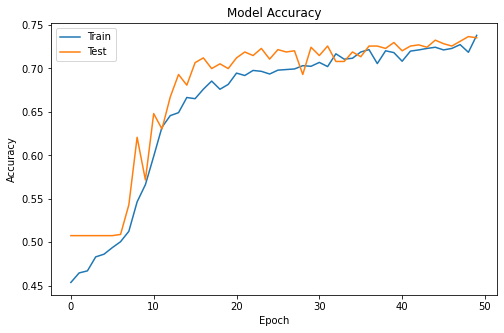

In [13]:
plt.figure(figsize=(8,5))

plt.plot(m1['accuracy'])
plt.plot(m1['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

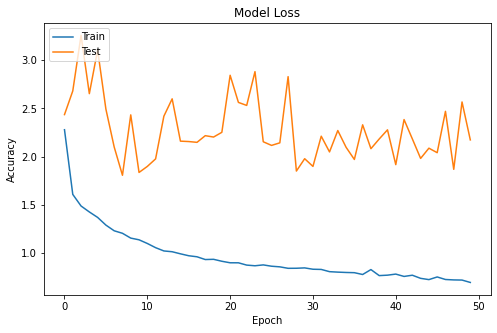

In [14]:
plt.figure(figsize=(8,5))

plt.plot(m1['loss'])
plt.plot(m1['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [15]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.
2929/2929 [==============================] - 276s 94ms/step


In [16]:
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

Train Accuracy score : 0.741


In [17]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

733/733 [==============================] - 68s 93ms/step


In [18]:
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))

Test Accuracy score : 0.735


In [8]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

In [9]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

NameError: name 'test_labels' is not defined